# Timings and stencils

This assignment is meant to be run on a node with 28 cores.

One thing we are trying to do is gauge the performance of a good MPI implementation and compare it to a good OpenMP implementation.  In order to do this, we will have to load some slightly different modules.

In [2]:
module unload cse6230
module load cse6230/mvapich
module list

|                                                                         |
|       A note about python/3.6:                                          |
|       PACE is lacking the staff to install all of the python 3          |
|       modules, but we do maintain an anaconda distribution for          |
|       both python 2 and python 3. As conda significantly reduces        |
|       the overhead with package management, we would much prefer        |
|       to maintain python 3 through anaconda.                            |
|                                                                         |
|       All pace installed modules are visible via the module avail       |
|       command.                                                          |
|                                                                         |
Currently Loaded Modulefiles:
  1) curl/7.42.1
  2) hwloc/1.10.0(default)
  3) git/2.13.4
  4) python/3.6
  5) /nv/coc-ice/tisaac3/opt/pace-ice/modulefiles/jupyter/

([mvapich](http://mvapich.cse.ohio-state.edu/) is a fork of the [mpich](https://www.mpich.org/) MPI implementation with some modifications for performance on various HPC hardware)

## Measuring MPI primitives

**Task 1 (3 pts)** The file `benchmarks.c` includes some basic benchmarks for measuring the performance of various MPI point-to-point and collective operations.  Right now, it is incomplete!

In [4]:
grep "TODO" benchmarks.c

  /* TODO: split the communicator `comm` into one communicator for ranks
  /* TODO: destroy the subcommunicator created in `splitCommunicator` */
  /* TODO: insert a barrier on `comm` to synchronize the processes */
  /* TODO: Record the MPI walltime in `tic_p` */
  /* TODO: Get the elapsed MPI walltime since `tic_in`,
  /* TODO: take the times from all processes and compute the maximum,
          /* TODO: Use the subComm communicator to broadcast from rank 0 the
          /* TODO: Use the subComm communicator to scatter from rank 0 the first
          /* TODO: Use the subComm communicator to compute the minimum of the
          /* TODO: Use the subComm communicator to gather the first `numBytes`
          /* TODO: Use the subComm communicator to sum the first `numBytes`
          /* TODO: Use the subComm communicator to gather the first `numBytes`
          /* TODO: Use the subComm communicator to transpose the first


Refering to a good [MPI Tutorial](https://computing.llnl.gov/tutorials/mpi/) or
[lecture notes](http://vuduc.org/cse6230/slides/cse6230-fa14--06-mpi.pdf) as needed,
fill in the missing MPI routines.

Once you have done that, run the following script to generate a graph of benchmark bandwidths of MPI routines.  Note that these values are only for MPI messages within a node: values may be different when we start using multiple nodes. 

In [14]:
make runbenchmarks

mpiexec -bind-to core -n 28 ./benchmarks | xvfb-run python figgen.py
('Send/Recv', [8, 64, 512, 4096, 32768, 262144, 2097152, 16777216], [-32.0, -256.0, -2048.0, -16384.0, -131072.0, -1048580.0, -8388610.0, -67108900.0])
/nv/usr-local-rhel6.7/pacerepov1/python/3.6/lib/python3.6/site-packages/matplotlib/ticker.py:2210: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  "Data has no positive values, and therefore cannot be "
('Bcast', [8, 64, 512, 4096, 32768, 262144, 2097152, 16777216], [-24.0, -192.0, -1536.0, -12288.0, -98304.0, -786432.0, -6291460.0, -50331600.0])
('Scatter', [8, 64, 512, 4096, 32768, 262144], [-24.0, -192.0, -1536.0, -12288.0, -98304.0, -786432.0])
('Reduce', [8, 64, 512, 4096, 32768, 262144, 2097152, 16777216], [-24.0, -192.0, -1536.0, -12288.0, -98304.0, -786432.0, -6291460.0, -50331600.0])
('Gather', [8, 64, 512, 4096, 32768, 262144], [-24.0, -192.0, -1536.0, -12288.0, -98304.0, -786432.0])
('Allreduce', [8, 64, 512, 4096, 32768, 2621

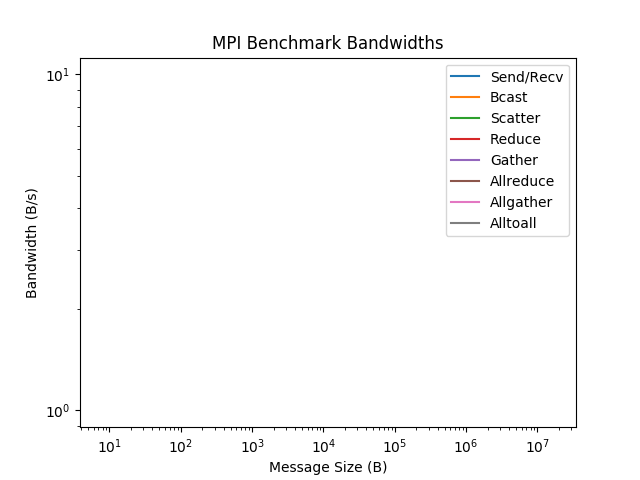

In [15]:
display < benchmarks.png

(Right now the graph is showing no values because the "timing" values are negative until you complete the code)

**Task 2 (2 pts)** We've talked in class about a simplified model of the cost of an MPI message: $\lambda + g b$, where $\lambda$ is the latency and $g$ is the inverse bandwidth.
Using your graph for Send/Recv bandwidths for different message sizes (which was simply calculated from dividing the message size by the message time), estimate $\lambda$ (units 1/secs) and $g$ (units bytes/sec) for this MPI implementation on this node.

## From particles to stencils

Project 1 showed one way to deal with the $O(n^2)$ bottleneck for computing $n$-body calculations directly: modify the potential so that it acts locally.

In this assignment, we consider a different approach.  The common inverse-square-law potential $\phi$ generated by a particle at location $x$ solves (in a certain sense) a partial differential equation (PDE):

$$-\Delta \phi = \delta(x),$$

Where the differential operator on the right is the Laplacian, and $\delta(x)$ indicates a point mass (or point charge, depending on the setting).  The PDE is linear, so the potential due to all of the particles can be written as

$$-\Delta \phi = \sum_p \delta(x_p).$$

PDEs, if you are not familiar, can be approximately solved very efficiently on a regular grid, where the action of $\Delta$ is approximated by a stencil operation.  A strategy for evolving the $n$-body problem can thus take the following form:

1. Approximate the sum of delta functions $\sum_p \delta(x_p)$ as a grid function $f$ by
   adding the mass/charge of each particle to one or more points in the grid.  (This is a
   local operation and is not difficult to make efficient).

2. Solve $-\Delta \phi = f$.  (This is where all of the effort is.)

3. The acceleration due to the potential at a point $x$ is approximately $\nabla \phi (x)$.

Therefore numerical methods, like the Jacobi smoother that we discussed in the context of cache-blocking for stencils, can be employed for $n$-body simulations.

I've written a small code that implements a 3D Jacobi smoother.  The applies a smoother `NT` times on a grid of size `BX` by `BY` by `BZ` (the $z$ direction is the fastest varying, that is, the leftmost index in FORTRAN or the rightmost index in C) that can be run three ways:

1. As a pure MPI code.  Here `MPI_N` is the total number of MPI processes,
`MPI_X`, `MPI_Y`, and `MPI_Z` are the number of processes in each direction.

In [20]:
make runpoisson MPI_N=8 MPI_X=2 MPI_Y=2 MPI_Z=2 BX=4 BY=4 BZ=4 NT=1000

OMP_NUM_THREADS=1 OMP_PROC_BIND=spread mpiexec -bind-to core -n 8 ./poisson 2 2 2 1 1 1 4 4 4 1 1000
[2 x 2 x 2] processes, [1 x 1 x 1] threads per process, [4 x 4 x 4] boxes, 1 particles, 1000 smoother steps
Sweep time: 0.00609207 seconds (0.00572658 seconds communication)
Rate: 1.05055e+07 lattice updates per second
Rate: 174624 halo exchanges per second


2. As a pure openMP code, with `OMP_N`, `OMP_X`, `OMP_Y`, and `OMP_Z` options

In [21]:
make runpoissonomp OMP_N=8 OMP_X=2 OMP_Y=2 OMP_Z=2 BX=4 BY=4 BZ=4 NT=1000

OMP_NUM_THREADS=8 OMP_PROC_BIND=true ./poisson 1 1 1 2 2 2 4 4 4 1 1000
[1 x 1 x 1] processes, [2 x 2 x 2] threads per process, [4 x 4 x 4] boxes, 1 particles, 1000 smoother steps
Sweep time: 0.00851107 seconds (0.00311232 seconds communication)
Rate: 7.51962e+06 lattice updates per second
Rate: 321304 halo exchanges per second


3. As a hybrid MPI+openMP code:

In [24]:
make runpoisson MPI_N=8 MPI_X=2 MPI_Y=2 MPI_Z=2 OMP_N=8 OMP_X=2 OMP_Y=2 OMP_Z=2 BX=8 BY=8 BZ=8 NT=10

OMP_NUM_THREADS=8 OMP_PROC_BIND=spread mpiexec -bind-to core -n 8 ./poisson 2 2 2 2 2 2 8 8 8 1 10
[2 x 2 x 2] processes, [2 x 2 x 2] threads per process, [8 x 8 x 8] boxes, 1 particles, 10 smoother steps
Sweep time: 0.162711 seconds (0.145163 seconds communication)
Rate: 31466.8 lattice updates per second
Rate: 68.888 halo exchanges per second


We will explore whether these implementations match our expectations for how quickly a Jacobi smoother can be applied, and whether there is any significant performance difference between them.

**Task 3 (2 pts)** We measure the performance of a stencil code in *Lattice updates per second*: a measure of how quickly we can process a grid point.  Our Jacobi smoother has two steps at each grid point.

1. Apply the smoother to the 7-point stencil: $v_{i,j,k} \leftarrow \frac{1}{6} (f_{i,j,k} + u_{i\pm 1, j\pm 1, k\pm 1})$, where $(i\pm 1, j\pm 1, k\pm 1)$ is every grid point that differs from $(i,j,k)$ in one direction (there are six).
2. Copy $u_{i,j,k} \leftarrow v_{i,j,k}$

It looks like there are 7 reads and one write in the first loop, but if the size of the array in each direction is small enough for a [layer condition](https://rrze-hpc.github.io/layer-condition/), then only one value of $u$ must be read instead of six.
The best memory traffic we can hope for then, is two reads ($f$ and $u$) and one write ($v$) per grid point in the first loop, an one read ($v$) and one write ($u$) per grid point in the second loop, for a total of 5 doubles, or **40 bytes per grid point**.

In our assignment on the [stream benchmark](https://www.cs.virginia.edu/stream/),
we estimated the peak bandwidh of this type of node at about **100 Gbytes / sec**.

Using these data points, estimate an upper bound on how many lattice updates per second (LUPs) our Jacobi smoother can accomplish on a large array that doesn't fit in cache.  Give that value in the cell below, and find a way of calling the MPI version of the code that

- Runs on a big enough problem (You may want to use `lstopo` or similar)
- Runs for about a second
- Gets close to the theoretical LUPs predicted

In [27]:
make runpoisson MPI_N=8 MPI_X=2 MPI_Y=2 MPI_Z=2 BX=4 BY=4 BZ=4 NT=1000

mpicc -qopenmp -I../../utils -g -Wall -O3 -xHost -std=c99 -c -o poisson.o poisson.c
mpicc -qopenmp -o poisson poisson.o jacobi.o cloud_util.o 
OMP_NUM_THREADS=1 OMP_PROC_BIND=spread mpiexec -bind-to core -n 8 ./poisson 2 2 2 1 1 1 4 4 4 1 1000
[2 x 2 x 2] processes, [1 x 1 x 1] threads per process, [4 x 4 x 4] boxes, 1 particles, 1000 smoother steps
Sweep time: 0.00614905 seconds (0.0057888 seconds communication)
Rate: 1.04081e+07 lattice updates per second
Rate: 21593.4 halo exchanges per MPI process per second


**Task 4 (2 pts)** What is the most LUPs you can achieve on this node, using either the MPI or OpenMP code?  Give that command below.

(I give you the choice of using MPI or OpenMP, but you may find it challenging to find an example where their performance is signficantly different.  As I said, you can accomplish just about the same things with both tools, the more important question is what is the best design for your code: threads or processes.)

If you choose a problem small enough to fit in cache, you will be able to do better than
the rate from the previous task.  But too small and the overhead of parallelization will outweigh the benefits.

In [26]:
make runpoissonomp OMP_N=8 OMP_X=2 OMP_Y=2 OMP_Z=2 BX=4 BY=4 BZ=4 NT=1000

OMP_NUM_THREADS=8 OMP_PROC_BIND=true ./poisson 1 1 1 2 2 2 4 4 4 1 1000
[1 x 1 x 1] processes, [2 x 2 x 2] threads per process, [4 x 4 x 4] boxes, 1 particles, 1000 smoother steps
Sweep time: 0.00890303 seconds (0.00302553 seconds communication)
Rate: 7.18857e+06 lattice updates per second
Rate: 330520 halo exchanges per second


**Task 5 (1 pt)** If a halo exchange (when the subgrid of an MPI process exchanges its boundary values with its neighbors) consists of 6 `MPI_Sendrecv`s (two in each direction),
then what does your $\lambda$ value above predict is the most halo exchanges per second that can be achieved per MPI process per second?  Give a command where you try to maximize the number of halo exchanges per MPI process per second below (using all 28 MPI processes).